In [41]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# Model for MNIST dataset

## Prepare data

In [42]:
train_data = datasets.MNIST(root="datasets",
                            train=True,
                            download=True,
                            transform=ToTensor())
test_data = datasets.MNIST(root="datasets",
                           train=False,
                           download=True,
                           transform=ToTensor())

In [43]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

BATCH_SIZE = 128

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e5968f74d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e594192e90>)

In [50]:
next(iter(train_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

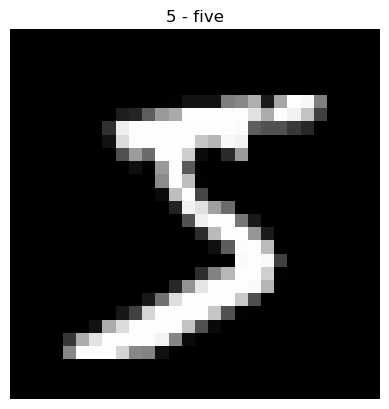

In [36]:
import matplotlib.pyplot as plt

image, label = next(iter(train_data))
plt.imshow(X=image.squeeze(), cmap='gray')
plt.axis(False)
plt.title(train_data.classes[label]);

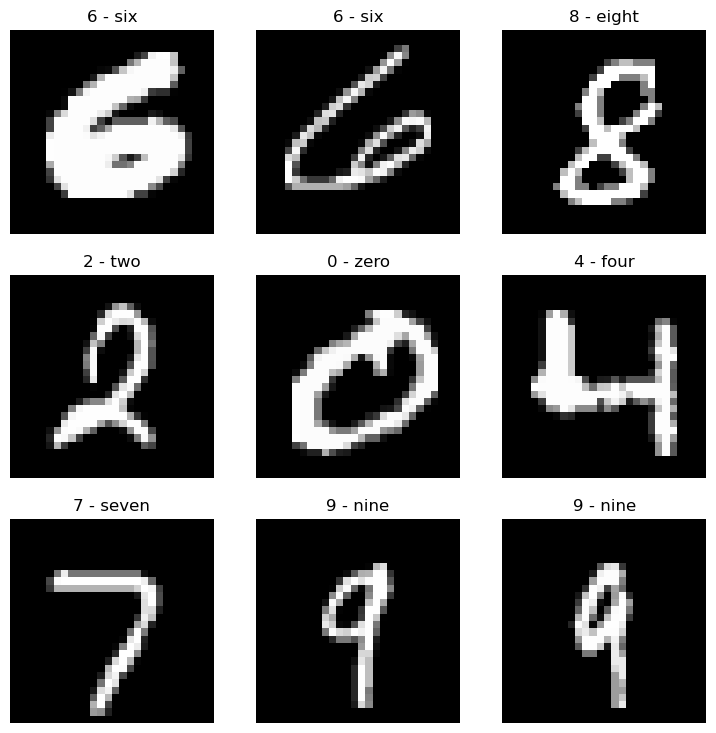

In [37]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample = torch.randint(0, len(train_data), size=(1,)).item()
    image, label = train_data[sample]
    fig.add_subplot(rows, cols, i)
    plt.imshow(X=image.squeeze(), cmap="gray")
    plt.axis(False)
    plt.title(train_data.classes[label])

## Bulding the model

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [39]:
from torch import nn
torch.manual_seed(42)

class MNISTmodel(nn.Module):
    """Custom model for MNIST dataset"""
    def __init__(self, in_features: (int, int), hidden_units: int, out_features: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features[0]*in_features[1],
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=out_features)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    
model0 = MNISTmodel(in_features=(28, 28),
                    hidden_units=64,
                    out_features=10)
model0.to(device)
model0, next(model0.parameters()).device

(MNISTmodel(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=64, bias=True)
     (2): ReLU()
     (3): Linear(in_features=64, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

In [40]:
model0.eval()
random_preds = []
with torch.inference_mode():
    for idx, (X, y) in enumerate(test_data):
        X = X.to(device)
        random_logits = model0(X)
        random_probs = torch.softmax(random_logits.squeeze(), dim=0)
        random_pred = random_probs.argmax(dim=0)
        if (idx % 2000 == 0):
            print(random_probs)
        random_preds.append(random_pred.cpu())
random_preds = torch.stack(random_preds)
random_preds

tensor([0.1118, 0.1140, 0.0956, 0.0943, 0.1040, 0.0848, 0.1063, 0.0914, 0.1010,
        0.0967], device='cuda:0')
tensor([0.1007, 0.1093, 0.0906, 0.0881, 0.1029, 0.0896, 0.1199, 0.0954, 0.1096,
        0.0939], device='cuda:0')


KeyboardInterrupt: 

In [ ]:
from helper_functions import accuracy_fn

random_model0_accuracy = accuracy_fn(test_data.targets, random_preds)
print(f"Model accuracy before training: {random_model0_accuracy:.2f}%")

Model accuracy before training: 10.88%


## Training model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

In [ ]:
def train_step(model: nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training step with the given dataloader"""
    model.train()

    train_acc = 0
    train_loss = 0
    for X, y in train_dataloader:
        model.zero_grad()

        # Everything on the same device
        X, y = X.to(device), y.to(device)

        # Prediction
        train_logits = model(X)

        # Accuracy
        train_probs = torch.softmax(train_logits.squeeze(), dim=1)
        train_preds = train_probs.argmax(dim=1)
        train_acc += accuracy_fn(y_true=y, y_pred=train_preds)

        # Loss
        loss = loss_fn(train_logits, y)
        train_loss += loss
        loss.backward()

        # Optimizer
        optimizer.step()
    
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    return train_acc, train_loss

In [ ]:
def test_step(model: nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a testing step with the given dataloader"""
    model.eval()

    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            test_logits = model(X)
            test_probs = torch.softmax(test_logits.squeeze(), dim=1)
            test_preds = test_probs.argmax(dim=1)
            test_acc += accuracy_fn(y_true=y, y_pred=test_preds)
            test_loss += loss_fn(test_logits, y)

        test_acc /= len(test_dataloader)
        test_loss /= len(test_dataloader)
    return test_acc, test_loss

In [ ]:
from timeit import default_timer as timer
from helper_functions import print_train_time
torch.manual_seed(42)

EPOCHS = 20
epoch_values = []
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

train_start_time = timer()
for epoch in range(1, EPOCHS+1):
    print(f"Epoch: {epoch}")
    print("---------------")
    train_acc, train_loss = train_step(model=model0,
                                       train_dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)
    print(f"Train loss: {train_loss:.4f} | Test acc: {train_acc:.4f}")
    test_acc, test_loss = test_step(model=model0,
                                    test_dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    print()

    epoch_values.append(epoch)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc/100)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc/100)

train_end_time = timer()
model_train_time = print_train_time(start=train_start_time,
                                    end=train_end_time,
                                    device=device)

Epoch: 1
---------------
Train loss: 1.7530 | Test acc: 58.4788
Test loss: 1.0942 | Test acc: 80.0336

Epoch: 2
---------------
Train loss: 0.8142 | Test acc: 82.5793
Test loss: 0.6080 | Test acc: 85.8188

Epoch: 3
---------------
Train loss: 0.5531 | Test acc: 86.4361
Test loss: 0.4799 | Test acc: 87.9252

Epoch: 4
---------------
Train loss: 0.4606 | Test acc: 87.9842
Test loss: 0.4134 | Test acc: 89.2504

Epoch: 5
---------------
Train loss: 0.4134 | Test acc: 88.8559
Test loss: 0.3761 | Test acc: 89.8536

Epoch: 6
---------------
Train loss: 0.3844 | Test acc: 89.3812
Test loss: 0.3528 | Test acc: 90.3085

Epoch: 7
---------------
Train loss: 0.3642 | Test acc: 89.8859
Test loss: 0.3388 | Test acc: 90.6448

Epoch: 8
---------------
Train loss: 0.3490 | Test acc: 90.2341
Test loss: 0.3265 | Test acc: 91.0601

Epoch: 9
---------------
Train loss: 0.3368 | Test acc: 90.5228
Test loss: 0.3145 | Test acc: 91.2085

Epoch: 10
---------------
Train loss: 0.3266 | Test acc: 90.7377
Test los

KeyboardInterrupt: 

## Model performance

In [ ]:
# To avoid training again

epoch_values = list(range(1, EPOCHS+1))
with torch.inference_mode():
    train_loss_values = torch.stack(train_loss_values).cpu()
    test_loss_values = torch.stack(test_loss_values).cpu()
train_loss_values, test_loss_values

(tensor([1.7530, 0.8142, 0.5531, 0.4606, 0.4134, 0.3844, 0.3642, 0.3490, 0.3368,
         0.3266, 0.3178, 0.3097, 0.3024, 0.2956, 0.2893, 0.2835, 0.2780, 0.2726,
         0.2676, 0.2628]),
 tensor([1.0942, 0.6080, 0.4799, 0.4134, 0.3761, 0.3528, 0.3388, 0.3265, 0.3145,
         0.3088, 0.3016, 0.2947, 0.2893, 0.2877, 0.2759, 0.2726, 0.2683, 0.2707,
         0.2583, 0.2571]))

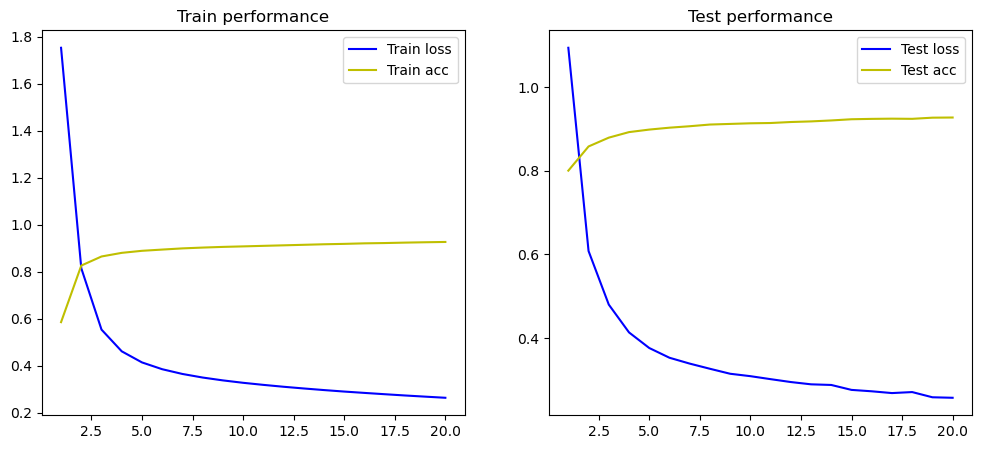

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
plt.plot(epoch_values, train_acc_values, c='y', label='Train acc')
plt.title('Train performance')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epoch_values, test_loss_values, c='b', label='Test loss')
plt.plot(epoch_values, test_acc_values, c='y', label='Test acc')
plt.title('Test performance')
plt.legend();

## Plotting some predictions

In [ ]:
def make_predictions(model: nn.Module,
                     test_data: list,
                     device: torch.device = device):
    """Performs predictions on the given model with the given test data.\n
       Returns a tuple containing the predicted label and its probability according to the model, respectively."""
    model.eval()
    preds_with_probs = []
    with torch.inference_mode():
        for X in test_data:
            X = X.to(device)
            pred_logits = model(X)
            pred_probs = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_with_prob = (pred_probs.argmax(dim=0), pred_probs.max(dim=0)[0].item())
            preds_with_probs.append(pred_with_prob)
    return preds_with_probs

In [ ]:
import random
#random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
test_labels, len(test_labels)

([9, 6, 2, 9, 3, 2, 2, 3, 6], 9)

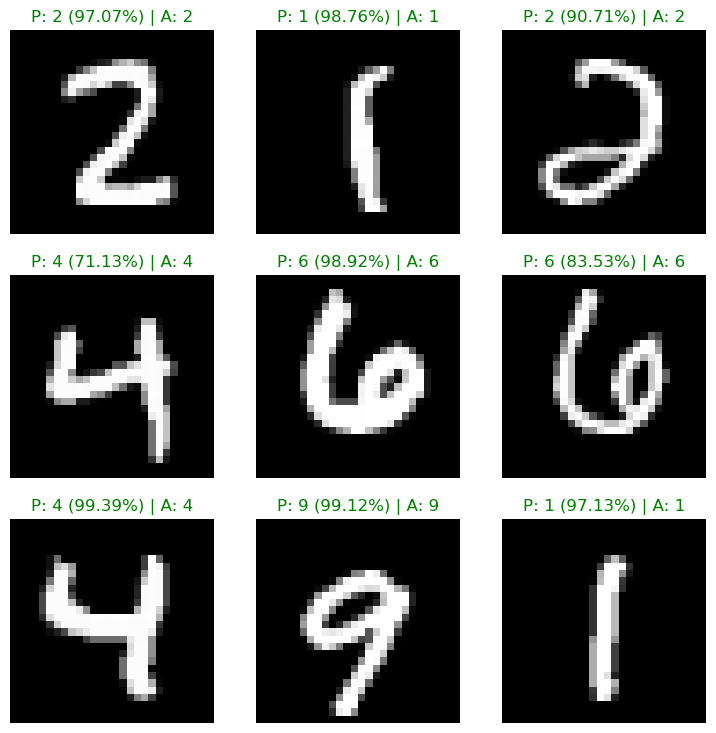

In [ ]:
preds_with_probs = make_predictions(model=model0,
                                    test_data=test_samples,
                                    device=device)

fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    plt.subplot(rows, cols, i)
    plt.imshow(X=test_samples[i-1].squeeze(), cmap='gray')
    plt.axis(False)
    predicted = preds_with_probs[i-1][0]
    prediction_prob = preds_with_probs[i-1][1]
    actual = test_labels[i-1]
    title = f"P: {preds_with_probs[i-1][0]} ({prediction_prob*100:2.2f}%) | A: {actual}"
    if predicted == actual:
        plt.title(title, c='g')
    else:
        plt.title(title, c='r')

## Plotting the confusion matrix

In [ ]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="MULTICLASS", num_classes=10)
confmat

ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
def make_all_predictions(model: nn.Module,
                         data: torch.utils.data.DataLoader,
                         device: torch.device = device):
    """Makes predictions on all the testing data (test dataloader).\n
       Returns a tuple with the predictions and actual labels, respectively"""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_preds = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)
            all_preds.append(y_preds.cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

In [ ]:
torch.manual_seed(42)

all_preds, all_labels = make_all_predictions(model=model0,
                                             data=test_dataloader,
                                             device=device)
confmat_tensor = confmat(all_preds, all_labels)
confmat_tensor

tensor([[ 958,    0,    2,    2,    0,    5,    8,    2,    3,    0],
        [   0, 1109,    2,    2,    0,    1,    4,    2,   15,    0],
        [  10,    6,  927,   15,    9,    1,   14,   12,   33,    5],
        [   2,    0,   20,  930,    0,   19,    2,   13,   17,    7],
        [   1,    1,    3,    2,  921,    0,   11,    2,    9,   32],
        [  10,    2,    6,   39,    8,  777,   16,    6,   20,    8],
        [  12,    3,    4,    1,   10,   10,  913,    2,    3,    0],
        [   3,    9,   27,    6,    6,    0,    0,  949,    2,   26],
        [   8,    7,    5,   19,    8,   12,   12,   10,  887,    6],
        [  10,    7,    1,   10,   37,    7,    1,   13,    6,  917]])

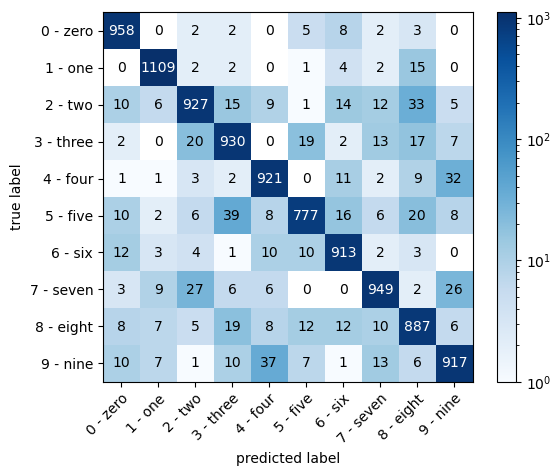

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import LogNorm

confmat_tensor = confmat_tensor.numpy()
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor,
                                colorbar=True,
                                class_names=test_data.classes,
                                norm_colormap=LogNorm())

## Saving the model

In [ ]:
from pathlib import Path

PATH = Path("models")
PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "H01-MNISTModel.pth"
SAVING_MODEL_PATH = PATH / MODEL_NAME

torch.save(model0.state_dict(), SAVING_MODEL_PATH)

In [ ]:
loaded_model0 = MNISTmodel(in_features=(28, 28),
                           hidden_units=64,
                           out_features=10)
loaded_model0.to(device)
loaded_model0.load_state_dict(torch.load(SAVING_MODEL_PATH))

<All keys matched successfully>

In [ ]:
torch.manual_seed(42)

loaded_model0_preds, _ = make_all_predictions(model=loaded_model0,
                                              data=test_dataloader,
                                              device=device)
torch.eq(loaded_model0_preds, all_preds)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
model1 = MNISTmodel(in_features=(28, 28), hidden_units=64, out_features=10)

In [ ]:
import random
#random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
test_labels, len(test_labels)

([9, 0, 9, 0, 1, 1, 4, 2, 1], 9)

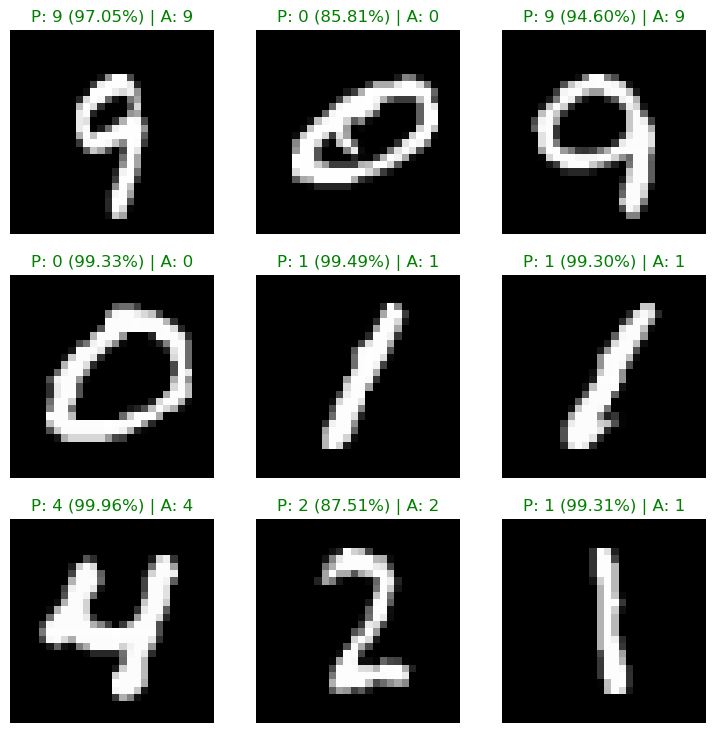

In [ ]:
preds_with_probs = make_predictions(model=model0,
                                    test_data=test_samples,
                                    device=device)

fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    plt.subplot(rows, cols, i)
    plt.imshow(X=test_samples[i-1].squeeze(), cmap='gray')
    plt.axis(False)
    predicted = preds_with_probs[i-1][0]
    prediction_prob = preds_with_probs[i-1][1]
    actual = test_labels[i-1]
    title = f"P: {preds_with_probs[i-1][0]} ({prediction_prob*100:2.2f}%) | A: {actual}"
    if predicted == actual:
        plt.title(title, c='g')
    else:
        plt.title(title, c='r')